# Localization with a known map &mdash; Part 3 <br/> Enhancing Inference with Grid Proposals 
 <!-- "Enhancing Localization Inference: Grid Proposals and Comparison with Standard Particle Filters" -->

In the 3rd part of this tutorial our focus shifts to inference techniques using *grid proposals*. 
To begin, we will run a standard particle filter with a default proposal and MH drift move, as introduced in part 2. This will serve as our baseline for comparison. 
Subsequently, we will delve into the application of two different kinds of Metropolis-Hastings (MH) moves to improve pose inference.

The first MH move involves a proposal based on a fine-grained grid centered around the current robot pose. 

Next, we will employ a coarse-to-fine strategy, implemented as a series of MH moves as described previously. This strategy allows us to iteratively refine our localization estimates by gradually zooming in on the optimal solution. By incorporating multiple scales of proposals, we can enhance the overall inference process while keeping our computational resources in check.

In [1]:
# This is a fix for vscode, because it doesn't like my
# julia docstrings for whatever reason, and throws a `Katex` error.
using Markdown
Base.show(io::IO, ::MIME"text/latex", md::Markdown.MD) = plain(io, md)

In [2]:
function sortperm_them!(vals, vecs...)
    perm = sortperm(vals)
    id   = 1:length(vals)
    for v in [vals, vecs...]
        v[id] = v[perm]
    end
end;

argdiffs(bs::Array{T,1}) where T <: Real = Tuple(map(b -> Bool(b) ? UnknownChange() : NoChange(), bs));

In [3]:
include("src/localization_part_1.jl")
include("src/localization_part_2.jl")

Loading data from `../data/task_inputs/test_env_1.json`, and
populating Main namespace with variables:

_segs      Vector{Segment}
_boxes     Vector{Segment}
_center    Vector{Float64}
_xs        Vector{Vector{Float64}}
_hds       Vector{Float64}
_ps        Vector{Pose}
_dxs       Vector{Vector{Float64}}
_dhds      Vector{Float64}
_us        Vector{Control}
_T         Int64
Created a few new variables:

_obs_noise Float64
_fov       Float64
_as        Vector{Float64}
_zs        Vector{Vector{Float64}}
_ys        Vector{Vector{Vector{Float64}}}



DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Any, Any, Any, Any], true, Union{Nothing, Some{Any}}[nothing, nothing, nothing, Some([:x, :hd])], var"##pose_drift_proposal#436", Bool[0, 0, 0, 0], false)

## Recomputing the Task Inputs: Observations and Control Data

Perturb the control variables `_us` and create a noisy version `us_noisy`.
Create observations `_zs` along the path with given field of view and noise level.

[ Info: Saved animation to /home/ubuntu/workspace/probabilistic-slam-in-gen/notebooks/v2/_imgs/loc_data_gen.gif


Plots.AnimatedGif("/home/ubuntu/workspace/probabilistic-slam-in-gen/notebooks/v2/_imgs/loc_data_gen.gif")
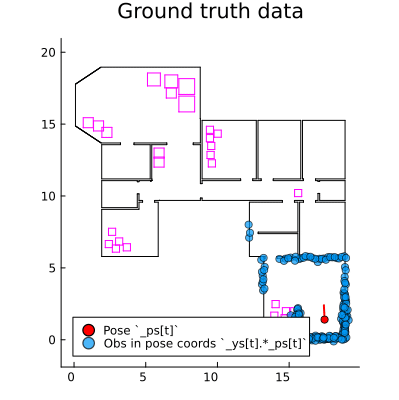

In [7]:
_obs_noise = 0.1
_fov       = 2π
_num_a     = 361
_zs, _as, _ys = create_observations(_ps, vcat(_segs, _boxes), _fov, _num_a, _obs_noise)

_bb = bounding_box(_segs)
# -----------------------
ani = Animation()
for t=1:1:_T
    p = _ps[t]
    y = _ys[t]

    agent_plt = plot(
        size=(400,400), aspect_ratio=:equal, title="Ground truth data",  grid=false, showaxis=true,
        xlim=(_bb[1][1]-1, _bb[2][1]+1),
        ylim=(_bb[1][2]-2, _bb[2][2]+2)
    )
    plot!(_segs, c=:black, linewidth=1, label=nothing)
    plot!(_boxes, c=:magenta, label=nothing)
    plot!([p], c=:red, r=1.0, linewidth=2, label=nothing)
    scatter!([p.x], c=:red, label="Pose `_ps[t]`")
    scatter!(shuffle(y[1:2:end]).*p, c=col[1], markersize=4, alpha=.7, markerstrokewidth=1, label="Obs in pose coords `_ys[t].*_ps[t]`")

    frame(ani, agent_plt)
end
gif(ani, "_imgs/loc_data_gen.gif", fps=4) # gif(ani, fname, fps=10)

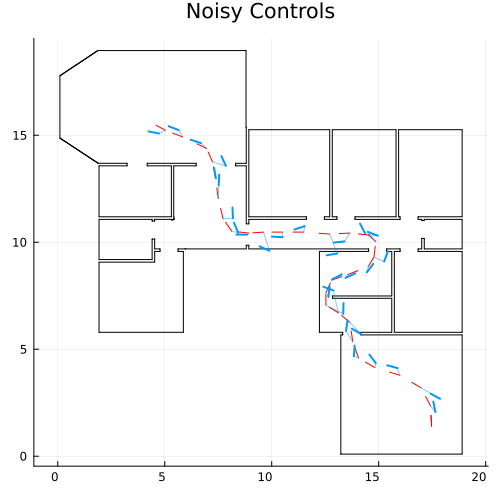

In [8]:
x_noise  = 0.4
hd_noise = 15/360*2π
us_noisy = perturb.(_us, x_noise, hd_noise);
u0_noisy = perturb(Control([0.,0.],0), x_noise, hd_noise)

rel_ps = [p+u for (p,u) in zip(_ps[1:end-1],us_noisy)];
ps     = [_ps[1]]
for u in us_noisy
    push!(ps, ps[end] + u)
end
# ---------------------
myplot = plot(size=(500,500), 
    title="Noisy Controls",
    aspect_ratio=1., legend=nothing)
plot!(_segs, c=:black)
plot!(_ps[1], c=:red)
plot!(_ps, c=:red)
for (p,q) in zip(_ps[2:end],rel_ps)
    plot!(q, c=col[1], linewidth=2)
    plot!([p.x,q.x], c=col[1], alpha=0.5)
end
savefig("_imgs/loc_us_noisy.png")
display(myplot)

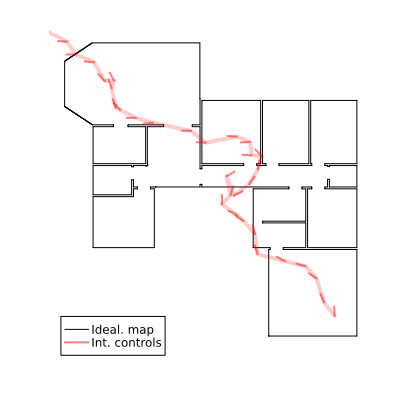

In [9]:
#nbx
x_noise  = 0.5
hd_noise = 5/360*2π
us_noisy = perturb.(_us, x_noise, hd_noise);

rel_ps = [p+u for (p,u) in zip(_ps[1:end-1],us_noisy)];
ps_noisy = [_ps[1]]
for u in us_noisy
    push!(ps_noisy, ps_noisy[end] + u)
end

# -----------------
env_plt = plot(
    size=(400,400), aspect_ratio=:equal, axis=false, grid=false,
    xlim=(_bb[1][1]-1, _bb[2][1]+1),
    ylim=(_bb[1][2]-2, _bb[2][2]+2),
    legend=:bottomleft,
)
plot!(_segs, c=:black, linewidth=1, label="Ideal. map")
plot!([p.x for p in ps_noisy], c=:red, label=nothing, alpha=0.2, linewidth=4)

plot!(ps_noisy[1],     c=:red,  r=.6, label="Int. controls", alpha=0.5, linewidth=2)
plot!(ps_noisy[2:end], c=:red,  r=.6,  label=nothing,  alpha=0.5, linewidth=2)
savefig("_imgs/loc_noisy_contr.png")
env_plt

## Vector Grids

Build the base for our grid proposals ...

In [10]:
#nbx
"""
Discretize into bins of diameter r, bin-centers lie 
at `z - k*r` for intergers `k`.
"""
quantize(x, r; zero=0) = Int.(floor.((x .+ r./2 .- zero)./r))

quantize

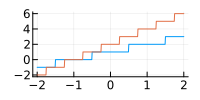

In [11]:
xs  = -2:0.01:2
# ----------------- 
plot(size=(200,100))
plot!(xs, quantize.(xs, 1.0; zero=-1), legend=nothing)
plot!(xs, quantize.(xs, 0.5; zero=-1), legend=nothing)

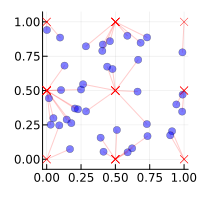

In [12]:
r  = [0.5, 0.5]
xs = unstack(rand(40,2))
is = quantize.(xs, [r])
# ------------------------
mypl = plot(size=(200,200), aspect_ratio=:equal, legend=nothing)
for (x,i) in zip(xs, is)
    y = i.*r
    plot!([x,y], c=:red, alpha=0.2)
    scatter!([x], c=:blue, alpha=0.5)
    scatter!([y], c=:red, marker=:x)
    
end
mypl

**Vector Grids.** In our contrect a vector grid is defined by a triple `(v0,k,r)`, where
-  `v0` is a vector defining the center of the grid,
-  `k` is a integer vector that contains the number of grid points in each dimension, and
-  `r` is a float vector that contains the resolution along each dimension.

In [13]:
#nb
"""
    get_offset(v0, k, r)

Computes the offset to move the center 
of the grid to `v0`.
"""
function get_offset(v0, k, r)
    center = (r + k.*r)/2
    return v0 - center
end

function first_grid_vec(v0::Vector{Real}, k::Vector{Int}, r::Vector{Real})
    return r + get_offset(v0, k, r) 
end

"""
    vs, ls = vector_grid(v0, k, r)

Returns grid of vectors and their linear indices, given 
a grid center, numnber of grid points along each dimension and
the resolution along each dimension.
"""
function vector_grid(v0::Vector{Float64}, k::Vector{Int}, r::Vector{Float64})
    # Todo: Does it make sense to get a CUDA version of this?
    offset = get_offset(v0, k, r)
    
    shape = Tuple(k)
    cs = CartesianIndices(shape)
    ls = LinearIndices(shape)
    vs = map(I -> [Tuple(I)...].*r + offset, cs);
    return (vs=vs, linear_indices=ls)
end


function grid_index(x, v0, k, r; linear=false)
    I = quantize(x, r, zero=get_offset(v0, k, r));
    if linear
        shape = Tuple(k)
        I = LinearIndices(shape)[I...] 
    end
    return I
end

grid_index (generic function with 1 method)

In [14]:
v0 = rand(4)
k  = [10,10,10,10]
r  = [0.5,0.5,0.5,0.5]

x = rand(4)

@btime vector_grid(v0, k, r);
@btime grid_index(x, v0, k, r; linear=false);
@btime grid_index(x, v0, k, r; linear=true);

  1.427 ms (30016 allocations: 2.82 MiB)
  307.693 ns (5 allocations: 480 bytes)
  837.122 ns (10 allocations: 688 bytes)


Vector grid runtimes:
```julia
1.395 ms (30016 allocations: 2.82 MiB)
309.233 ns (5 allocations: 480 bytes)
922.537 ns (10 allocations: 688 bytes)
```

## Eval poses

We want to compute the likelihood of some observations for all the configurations in a grid.
To evaluate the pose vectors we use `sensor_logpdf` from `sensor_distribution.jl`, which we imported in Part 1.


In [15]:
@doc sensor_logpdf

```julia
    log_ps, ptw = sensor_logpdf(x, ỹ, sig, outlier, outlier_vol=1.0; return_pointwise=false)
```

Evaluates an observation `x` under the 2dp3 likelihood with <br/> a family of mixture components `ỹ` and parameters `sig`, `outlier`, and `outlier_vol`.

Arguments:

  * `x`: Observation point cloud `(n,2)`
  * `ỹ`: Family of mixture components `(k,n,m,2)`
  * `sig`: Std deviation of Gaussian mixture components; either a scalar or an array of shape `(1,1,1,1, ...)` (should be broadcastable with `outlier` and the rest)
  * `outlier`: Outlier probability; either a scalar or an array of shape `(1,1,1,1, ...)` (should be broadcastable with `sig` and the rest)

Returns:

  * `log_ps`: Log-probs `(k,)` ,or `(k, ...)` in case of non-scalar `sig` and `outlier`
  * `ptw`:    Pointwise log-probs for each observation point `(k,n)`  ,or `(k,n, ...)` in case of non-scalar `sig` and `outlier`


In [16]:
#nbx
"""
    log_ps, ps = eval_pose_vectors(
                    vs::Array{Vector{Float64}},
                    x::Vector{Vector{Float64}}, 
                    segs::Vector{Segment}, as::Vector{Float}, w::Int, 
                    s_noise::Float64, outlier::Float64, 
                    outlier_vol::Float64=1.0, zmax::Float64=100.0; sorted=false)

Evaluates a collection of poses 
with respect to different Gaussian mixtures...
"""
function eval_pose_vectors(
            vs::Array{Vector{Float64}},
            x::Vector{Vector{Float64}}, 
            segs, as, w::Int, 
            s_noise::Float64, outlier::Float64, outlier_vol::Float64=1.0, 
            zmax::Float64=100.0; sorted=false)
    
    # Compute sensor measurements and 
    # Gaussian mixture components
    # p_  = CuArray(Vector(p))
    # ps_ = reshape(p_, 1, 3)

    ps   = stack(vs[:])
    x    = stack(x)
    segs = stack(Vector.(segs))

    if _cuda[]
        ps   = CuArray(ps)
        x    = CuArray(x)
        segs = CuArray(segs)
        as   = CuArray(as)
    end
    

    zs = cast(ps, segs; fov=_fov, num_a=_num_a, zmax=zmax)
    ys_tilde = get_2d_mixture_components(zs, as, w)
        
    # Evaluate the the observations with respect to the 
    # different Gaussian mixtures computed above
    log_ps, = sensor_logpdf(x, ys_tilde, s_noise, outlier, outlier_vol; return_pointwise=false);
    
    # Move everyting back to CPU if is not already there
    log_ps = Array(log_ps)

    # Sort by log prob
    # and return 
    if sorted
        perm   = sortperm(log_ps)
        log_ps = log_ps[perm]
        vs     = vs[:][perm]
    end
    
    return log_ps, vs[:]
end;



In [26]:
# #nbx
# """
#     log_ps, ps = eval_pose_vectors(
#                     ps_::CuArray,
#                     x::Matrix, 
#                     ys_::CuArray, as_::CuArray, w::Int, 
#                     s_noise::Float64, outlier::Float64, 
#                     outlier_vol::Float64=1.0, zmax::Float64=100.0; sorted=false)

# Evaluates a collection of poses 
# with respect to different Gaussian mixtures...
# """
# function eval_pose_vectors_cu(
#             vs_::CuArray,
#             x_::CuArray, 
#             segs, as, w::Int, 
#             s_noise::Float64, outlier::Float64, outlier_vol::Float64=1.0, 
#             zmax::Float64=100.0; sorted=false)
    
#     # Compute sensor measurements and 
#     # Gaussian mixture components
#     # p_  = CuArray(Vector(p))
#     # ps_ = reshape(p_, 1, 3)

#     ps_   = CuArray(stack(vs[:]))
#     x_    = CuArray(stack(x))
#     segs_ = CuArray(stack(Vector.(segs)))
#     as_   = CuArray(as)

#     zs_       = cast(ps_, segs_; fov=_fov, num_a=_num_a, zmax=zmax)
#     ys_tilde_ = get_2d_mixture_components(zs_, as_, w)
        
#     # Evaluate the the observations with respect to the 
#     # different Gaussian mixtures computed above
#     log_ps_, = sensor_logpdf(x_, ys_tilde_, s_noise, outlier, outlier_vol; return_pointwise=false);
    
#     # Move everyting back to CPU
#     ps     = Vector.(eachrow(Array(ps_)))
#     log_ps = Array(log_ps_)

#     # Sort by log prob
#     # and return 
#     if sorted
#         perm   = sortperm(log_ps)
#         log_ps = log_ps[perm]
#         ps     = ps[perm]
#     end
    
#     return log_ps, ps
# end;

In [17]:
"""
    normalize_exp(x)

Apply `exp` then normalize. Actually, this is just `softmax` with temperature one, oh well...
"""
function normalize_exp(x)
    b = maximum(x)
    y = exp.(x .- b)
    return y / sum(y)
end;

"""
    raise_probs(p, vmin)

Raise a probaility vector to a minimal value.
"""
raise_probs(p, vmin) = (1 - vmin*length(p))*p .+  vmin;

(343,)(343,)(343,)


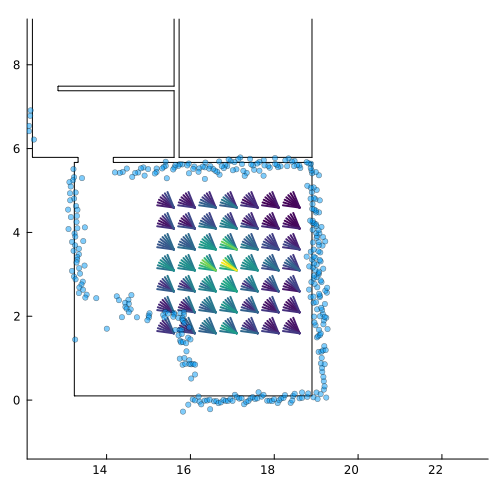

In [19]:
t  = 3
p0 = _ps[t] + control_prior_model(0.25, 5/180*π)
x  = _ys[t]

grid_args = (
    v0=Vector(p0), 
    k=[7,7,7],
    r=[0.5,0.5,10/180*π],
)

vs, = vector_grid(grid_args...)

sensor_args = ( 
    w           = 10,
    s_noise     = 0.1,
    outlier     = 1e-5,
    outlier_vol = 1e2,
    zmax        = 100.0,
)



log_ps, vs = eval_pose_vectors(vs, x, _segs, _as, sensor_args...; sorted=false);
ps = Pose.(vs)

sortperm_them!(log_ps, ps, vs)
println(size(ps), size(vs), size(log_ps))

# -----------------------------
delta = 6
mypl = plot(size=(500,500), legend=nothing, aspect_ratio=:equal,  grid=false, showaxis = true,
    xlim=(vs[1][1]-delta, vs[end][1]+delta),
    ylim=(vs[1][2]-delta, vs[end][2]+delta) 
)
plot!(_segs, c=:black)
cs = cgrad(:viridis)[peak_to_peak(log_ps)]
plot!(ps, cs, r=.4, linewidth=2)
scatter!(x .* ps[end], markerstrokewidth=0.5, c=col[1], alpha=0.5, markersize=3)
display(mypl)

## Proposals

Drift proposal, and the grid proposal ... we will use Gen's *Trace Transform DSL*...

In [20]:
@gen function pose_drift_proposal(tr, x_noise, hd_noise, vars=[:x,:hd])
    
    T, = get_args(tr)
    p  = get_pose(tr,T+1)

    if :x in vars 
        x  = {add_addr_prefix(T, :pose => :x)}  ~ diagnormal(p.x, [x_noise, x_noise])
    end

    if :hd in vars 
        hd = {add_addr_prefix(T, :pose => :hd)} ~ normal(p.hd, hd_noise)
    end
    
    tr
end;

### Grid Proposal

In [21]:
#nbx
@gen function grid_proposal_from_center(p::Pose, obs_vector::Vector{Vector{Float64}}, grid_args, sensor_args, 
                            tau::Float64 = 1.0, pmin::Float64 = 1e-6)
    #
    # Create pose vector grid
    # around given pose p
    #
    v0 = Vector(p)
    vs, ls = vector_grid(v0, grid_args...)

    #
    # Evaluate the pose grid with respect 
    # to the observation vector
    #
    log_ps, = eval_pose_vectors(vs, obs_vector, _segs, _as, sensor_args...; sorted=false);    

    #
    # Sample the new pose p′. 
    # Two brief notes:
    #
    #  1. We have to raise the probabilities to a non-zero 
    #     value otherwise we run into problems in MH updates.
    #
    #  2. Note that we don't assign the new pose to 
    #     a particular time-step -- this is done in 
    #     the transforms defined below.
    #
    # Todo: Make the size of the uniform sampling area an argument.
    #
    log_ps_tau = log_ps ./ tau
    probs      = normalize_exp(log_ps_tau)
    probs      = raise_probs(probs, pmin)
    j ~ categorical(probs)
    x′  = {:pose => :x}  ~ mvuniform(vs[j][1:2] -  grid_args.r[1:2]/2, vs[j][1:2] + grid_args.r[1:2]/2)
    hd′ = {:pose => :hd} ~   uniform(vs[j][3]   -  grid_args.r[3]  /2, vs[j][3]   + grid_args.r[3]  /2)

    return Pose(x′, hd′), (j, vs, ls, log_ps)
end;

In [22]:
#nbx
@gen function grid_proposal(tr::Gen.Trace, t_chain::Int, obs_vector, grid_args, sensor_args, 
    u::Control = Control([0.0;0.0],0.0),
    tau::Float64 = 1.0, pmin::Float64 = 1e-6)

    #
    # Convert from chain-time to model-time
    # extract pose from trace
    #
    t = t_chain + 1
    p = get_pose(tr, t)
    p = p + u

    re = {*} ~ grid_proposal_from_center(p, obs_vector, grid_args, sensor_args, tau, pmin)

    return re
end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Trace, Int64, Any, Any, Any, Control, Float64, Float64], true, Union{Nothing, Some{Any}}[nothing, nothing, nothing, nothing, nothing, Some(Control([0.0, 0.0], 0.0)), Some(1.0), Some(1.0e-6)], var"##grid_proposal#934", Bool[0, 0, 0, 0, 0, 0, 0, 0], false)

### Trace Transforms

In [23]:

#
# Involution to use the proposal in a MH move
#
@transform involution (tr, aux) to (tr′, aux′) begin
    # Here `aux` is the proposal-trace 
    # and `tr` the slam-trace
    _,t_chain,_,grid_args, = get_args(aux)

    x′  = @read(aux[:pose => :x] , :continuous)
    hd′ = @read(aux[:pose => :hd], :continuous)
    @write(tr′[add_addr_prefix(t_chain, :pose => :x )],  x′, :continuous)
    @write(tr′[add_addr_prefix(t_chain, :pose => :hd)], hd′, :continuous)
    
    x  = @read(tr[add_addr_prefix(t_chain, :pose => :x )], :continuous)
    hd = @read(tr[add_addr_prefix(t_chain, :pose => :hd)], :continuous)
    j = grid_index([x;hd], [x′;hd′], grid_args..., linear=true)
    @write(aux′[:j],   j, :discrete)
    @write(aux′[:pose => :x],   x, :continuous)
    @write(aux′[:pose => :hd], hd, :continuous)
end

#
# Transform to use the proposal in a PF update, i.e.
# read in pose at time t and propose pose at time t+1 
#
@transform transform (aux) to (tr) begin
    # Here `aux` is the proposal-trace 
    # and `tr` the slam-trace
    _,t_chain,_,grid_args, = get_args(aux)
    
    x  = @read(aux[:pose => :x], :continuous)
    hd = @read(aux[:pose => :hd], :continuous)
    @write(tr[add_addr_prefix(t_chain+1,:pose => :x)],   x, :continuous)
    @write(tr[add_addr_prefix(t_chain+1,:pose => :hd)], hd, :continuous)
end

TraceTransformDSLProgram(var"#237###transform_fn!#938", nothing)

## Testing 

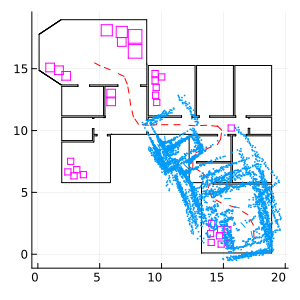

In [24]:
idealized = true
the_map   = idealized ? _segs : vcat(_segs, _boxes);

prior_args = ( 
    p0        = _ps[1],
    x0_noise  = .2,
    hd0_noise = 5/360*2π,
)

motion_args = ( 
    x_noise  = 0.2,
    hd_noise = 5/360*2π
)

sensor_args = (
    w           = 10,
    s_noise     = 0.1,
    outlier     = 1e-2,
    outlier_vol = 1e2,
    zmax        = 100.0,
)

args = (the_map, us_noisy, prior_args..., motion_args..., sensor_args...);

#
# Generate an example trace that will look badly
#
T = 10
ch = choicemap()
for t_chain=0:T
    ch[add_addr_prefix(t_chain, :sensor => :x)] = _ys[t_chain+1]
end
tr, = generate(static_slam_model, (T, args...), ch)

# ----------------------
mypl = plot(size=(300,300), legend=nothing, aspect_ratio=:equal)
plot_slam_trace!(tr)

grid size: 10000
  5.696018 seconds (7.69 M allocations: 430.729 MiB, 3.58% gc time, 99.74% compilation time)
  0.002041 seconds (2.25 k allocations: 192.922 KiB)
  0.001433 seconds (2.25 k allocations: 192.922 KiB)
  0.001437 seconds (2.25 k allocations: 193.219 KiB)
  0.001406 seconds (2.25 k allocations: 192.922 KiB)
  0.001399 seconds (2.25 k allocations: 193.094 KiB)
  0.001438 seconds (2.25 k allocations: 192.922 KiB)
  0.001350 seconds (2.20 k allocations: 188.594 KiB)
  0.001314 seconds (2.20 k allocations: 188.594 KiB)
  0.001354 seconds (2.20 k allocations: 188.594 KiB)
  0.001319 seconds (2.20 k allocations: 188.594 KiB)
  0.001900 seconds (2.25 k allocations: 193.391 KiB)
  0.001354 seconds (2.20 k allocations: 188.594 KiB)
  0.001344 seconds (2.20 k allocations: 188.594 KiB)
  0.001365 seconds (2.20 k allocations: 188.594 KiB)
  0.001352 seconds (2.20 k allocations: 188.594 KiB)
  0.001423 seconds (2.20 k allocations: 188.594 KiB)
  0.001374 seconds (2.20 k allocations: 18

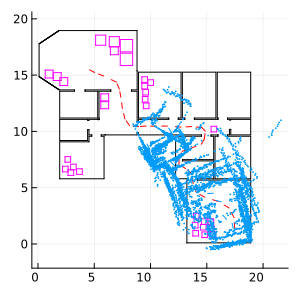

In [25]:
grid_args = (
    k = [21,21,21],
    r = [0.2, 0.2, 2/180*π]
)
sensor_args = (
    w           = 10,
    s_noise     = .1,
    outlier     = 1e-3,
    outlier_vol = 1e2,
    zmax        = 100.0,
)
println("grid size: $(prod(k))")

tr′ = tr
ws  = [project.([tr], [select(add_addr_prefix(t, :sensor => :x)) for t=0:T])]
for i=1:10
    for t_chain=0:T        
        prop_args =  (0.2, 2/180*π , [:x,:hd])
        @time tr′, acc = Gen.mh(tr′, pose_drift_proposal, prop_args)
        # obs_vector = _ys[t_chain+1]
        # @time tr′, acc = Gen.mh(tr′, grid_proposal, (t_chain, obs_vector, grid_args, sensor_args), involution)
    end
    push!(ws, project.([tr′], [select(add_addr_prefix(t, :sensor => :x)) for t=0:T]))
end


# -----------------------------
mypl = plot(size=(300,300), legend=nothing, aspect_ratio=:equal)
plot_slam_trace!(tr′)


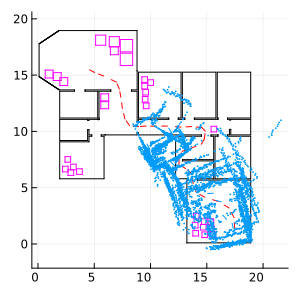

In [26]:
# -----------------------------
mypl = plot(size=(300,300), legend=nothing, aspect_ratio=:equal)
plot_slam_trace!(tr′)

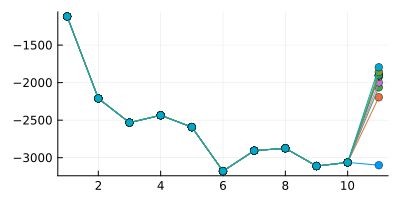

In [27]:
mypl = plot(size=(400,200), legend=nothing)
for w in ws
    plot!(w, marker=:o)
end
display(mypl)


## Experiments

In [28]:
using GenParticleFilters
using GenParticleFilters: update_refs!

grid_schedule(grid_args, i) = (k=grid_args.k, r=grid_args.r/2^(i-1)) 

grid_schedule (generic function with 1 method)

In [29]:

function pf_experiment(N, M, mh_move, update_type, idealized, 
    us, prior_args, motion_args, sensor_args, grid_args, grid_args_fine; verbose=false)

    the_map    = idealized ? _segs : vcat(_segs, _boxes);
    model_args = (the_map, us, prior_args..., motion_args..., sensor_args...);    
    
    # 
    # Initialize the PF
    # -----------------
    #
    ch = constraints(0,_zs,_as);

    # Update Version 1
    if update_type == :default

        state = pf_initialize(static_slam_model, (0, model_args...), ch, N);
    
    # Update Version 2
    elseif update_type == :fine_grid                

        obs_vector    = _ys[1]
        proposal_args = (prior_args.p0, obs_vector,  grid_args_fine, sensor_args);
        state = pf_initialize(static_slam_model, (0, model_args...), ch, 
                    grid_proposal_from_center, proposal_args, N);

    end

   

    # 
    # Unroll the PF
    # -----------------
    #
    diffs = argdiffs([1; zeros(length(args))])
    times = []
    for t=1:_T
        
        #
        # MH move
        # -------
        #
        if mh_move != :none && M > 0

            # MH Version 1: Multiple MH updates with drift proposal
            if mh_move == :drift
                
                pf_rejuvenate!(state, Gen.mh, (pose_drift_proposal, (0.1, 2/180*π, [:x, :hd])), M)

            # MH Version 2: Multiple MH updates with fine grid
            elseif mh_move == :fine_grid

                obs_vector = _ys[t]
                proposal_args = (t-1, obs_vector,  grid_args_fine, sensor_args);
                pf_rejuvenate!(state, Gen.mh, (grid_proposal, proposal_args, involution), M);

            # MH Version 3: Multiple MH updates with scheduled grid proposals
            elseif mh_move == :iterated_grid

                obs_vector = _ys[t]
                for (i, tr) in enumerate(state.traces)
                    for j = 1:M
                        proposal_args = (t-1, obs_vector, grid_schedule(grid_args, j), sensor_args);
                        tr, acc = Gen.mh(tr, grid_proposal, proposal_args, involution)
                    end
                    state.new_traces[i] = tr
                end
                update_refs!(state)

            end
        end

        # We don't want to resample the last step
        # plus we can't unroll further.
        if t < _T

            #
            # Resampling
            # ----------
            # Perform residual resampling (pruning low-weight particles),
            # or "classic" multinomeial resampling
            #
            resample = effective_sample_size(state) < 0.2*N
            if resample   
                method = [:multinomial,:residual][1]
                pf_resample!(state, method)
            end

            # used in all update types
            obs_vector = _ys[t+1] # t is chain-time here
            ch = choicemap(add_addr_prefix(t, :sensor => :x) => obs_vector)   

            #
            # PF update
            # ---------
            # Use the default proposal or a cutomized proposal to 
            # update the particles
            #

            # Update Version 1
            if update_type == :default

                pf_update!(state, (t, model_args...), diffs, ch)
            
            # Update Version 2
            elseif update_type == :fine_grid          

                u = us[t]
                proposal_args = (t-1, obs_vector, grid_args_fine, sensor_args, u);
                pf_update!(state, (t, model_args...), diffs, ch, grid_proposal, proposal_args, transform)

            end
        end


        if verbose
            println("$(resample), $(length(Set(state.parents)))")
        end
    end
    return state
end

pf_experiment (generic function with 1 method)

In [30]:
#
# Grid proposal args
#
grid_args = (
    k = [9,9,9],
    r = [0.3, 0.3, 3/180*π]
)
grid_args_fine = (
    k = [25,25,25],
    r = [0.1, 0.1, 1/180*π]
)

#
# Model args
#
the_map = idealized ? _segs : vcat(_segs, _boxes);
us      = us_noisy 
prior_args = ( 
    p0        = _ps[1] + u0_noisy,
    x0_noise  = .5,
    hd0_noise = 10/360*2π,
)
motion_args = ( 
    x_noise  = 0.2,
    hd_noise = 10/360*2π
)
sensor_args = (
    w           = 10,
    s_noise     = 0.1,
    outlier     = 1e-2,
    outlier_vol = 1e2,
    zmax        = 100.0,
)



(w = 10, s_noise = 0.1, outlier = 0.01, outlier_vol = 100.0, zmax = 100.0)

In [32]:

configs = [
    # (N=2,   M=1,  mh_move=:none, update_type=:fine_grid, idealized=true),
    # (N=2,   M=4,  mh_move=:iterated_grid, update_type=:default, idealized=true),
    # (N=2000, M=0,  mh_move=:none, update_type=:default, idealized=true),
    # (N=1000, M=0,  mh_move=:none, update_type=:default, idealized=true),
    # (N=100,  M=10, mh_move=:drift, update_type=:default, idealized=true),
    # (N=10,   M=1,  mh_move=:fine_grid, update_type=:default, idealized=true),
    # (N=50,   M=4,  mh_move=:iterated_grid, update_type=:default, idealized=true),
    (N=1,   M=0,  mh_move=:none, update_type=:fine_grid, idealized=true),
]

results = []
for c in configs
    print(c, " ...")
    exp_args = (c..., us, prior_args, motion_args, sensor_args, grid_args, grid_args_fine)
    sec = @elapsed state = pf_experiment(exp_args...)
    push!(results, (config=c, sec=sec, state=state))
    println("($(sec) secs)")
end

(N = 1, M = 0, mh_move = :none, update_type = :fine_grid, idealized = true) ...(4.555088718 secs)


In [33]:
#nbx
function plot_slam_trace!(tr; show_obs=true)
    T,m, = get_args(tr)
    ps = get_pose.([tr],1:T+1)
    xs = get_obs.([tr],1:T+1)
        
    plot!(_ps, c=:red, linewidth=2, alpha=0.5)
    plot!(ps, c=col[1])
    plot!(_segs,  c=:black)
    myplot = plot!(_boxes, c=:magenta)
    if show_obs
        for (x,p) in zip(xs, ps)
            myplot = scatter!(x .* p, c=col[1], markerstrokewidth=0, markersize=1, alpha=1.)
        end
    end
    return myplot
end

plot_slam_trace! (generic function with 1 method)

In [34]:
using Fmt: format, @f_str

In [35]:
using LinearAlgebra: norm
using LaTeXStrings

for re in results
    
    c      = re.config
    trs    = re.state.traces
    ws     = re.state.log_weights
    scores = get_score.(trs)

    perm   = sortperm(scores)
    trs    = trs[perm]
    ws     = ws[perm]
    scores = scores[perm]

    tr = trs[end]

    qs      = get_pose.([tr],1:_T)
    hd_err  = [abs(p.hd - q.hd) for (p,q) in zip(_ps, qs)]
    x_err   = [norm(p.x - q.x) for (p,q) in zip(_ps, qs)]
    data_lh = project.([tr], [select(add_addr_prefix(t,:sensor => :x)) for t=0:_T-1])
    

    # 
    # Annotation plot
    # 
    ann_plot = plot(xlim=(0,10),ylim=(0,10), showaxis = false, grid=false)
    annotate!(0, 10, text("""
Particles: $(c.N)
MH move:   $(c.mh_move)  (iters: $(c.M))
PF update: $(c.update_type)
Idealized: $(c.idealized)
Runtime:   $(ceil(re.sec*1000)/1000) sec ($(ceil(re.sec/_T*1000)/1000) sec/step: )
""", "Computer Modern", :left, :top, :green, 9))

    # 
    # Likelihood plot
    # 
    lh_plot = plot(size=(600,200))
    plot!(data_lh, label="data LH", marker=:o)

    # 
    # Error plot
    # 
    err_plot = plot(size=(600,200))
    plot!(hd_err, label="hd err", marker=:o)
    plot!(x_err, label="x e rr", marker=:o)

    # 
    # Trace plot
    # 
    tr_plot = plot(
        size=(300,300),  aspect_ratio=1., grid=false,
        legend=nothing, 
    )
    plot_slam_trace!(tr; show_obs=true)

    # 
    # Combined plot
    # 
    myplt = plot(tr_plot, ann_plot, err_plot, lh_plot, size=(800,400), 
        titlefont = font(5,"Computer Modern"),
        layout = @layout [
            a [grid(3,1)]
            ])
    display(myplt)
    savefig("_imgs/loc_$(c).png")
    
end

In [138]:
using LinearAlgebra: norm
using LaTeXStrings


lhs = []
labels = []

for (i,re) in enumerate(results)
    
    c      = re.config
    trs    = re.state.traces
    ws     = re.state.log_weights
    scores = get_score.(trs)

    perm   = sortperm(scores)
    trs    = trs[perm]
    ws     = ws[perm]
    scores = scores[perm]

    tr = trs[end]

    qs      = get_pose.([tr],1:_T)
    hd_err  = [abs(p.hd - q.hd) for (p,q) in zip(_ps, qs)]
    x_err   = [norm(p.x - q.x) for (p,q) in zip(_ps, qs)]
    data_lh = project.([tr], [select(add_addr_prefix(t,:sensor => :x)) for t=0:_T-1])
    
    push!(lhs, data_lh)
    push!(labels, (c.mh_move, c.update_type))

end

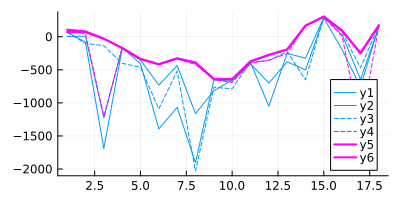

In [136]:
plot(size=(400,200))
plot!(1:_T, lhs[1], c=col[1], linewidth=1)
plot!(1:_T, lhs[2], c=col[1], linewidth=1)
plot!(1:_T, lhs[3], c=col[1], linewidth=1, linestyle=:dash)
plot!(1:_T, lhs[4], c=:magenta, linewidth=1, linestyle=:dash)
plot!(1:_T, lhs[5], c=:magenta, linewidth=2)
plot!(1:_T, lhs[6], c=:magenta, linewidth=2)

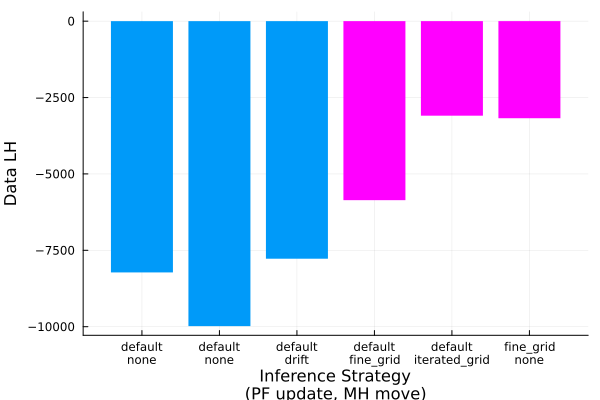

In [140]:

mypl = plot(size=(600,400), ylabel="Data LH", xlabel="Inference Strategy\n(PF update, MH move)")
# bar!(map(sum,lhs), c=col[1], xticks = (1:length(labels), map(x->"$(x[1])\n$(x[2])",labels)), label=nothing)
# scatter!(map(sum,lhs), 
bar!([map(sum,lhs), 1:6], linecolor=nothing,
    c=[col[1],col[1],col[1],:magenta, :magenta, :magenta], 
    # marker=[:o,:o,:o,:sq,:sq,:d], 
    # markersize=10,
    xticks = (1:length(labels), map(x->"$(x[2])\n$(x[1])",labels)), 
    label=nothing)

savefig("_imgs/loc_data_LH_bar_chart.png")
mypl

## Kidnapped Robot Experiments